In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
from tabulate import tabulate
from sklearn.cluster import KMeans
import seaborn as sns

In [25]:
# Retrieve the dataset
origin_data_2010_2011_df = pd.read_excel("./online_retail_II.xlsx", sheet_name='Year 2010-2011')

# View the data
unified_data = origin_data_2010_2011_df.copy()
unified_data.head(5)

summerized_data2 = unified_data.describe(include="object").T
print(tabulate(summerized_data2,headers=summerized_data2.columns,tablefmt='fancy_grid', stralign='center'))

summerized_data = unified_data.describe(datetime_is_numeric=True).T.drop(columns=["mean"])
print(tabulate(summerized_data,headers=summerized_data.columns,tablefmt='fancy_grid', stralign='center'))

╒═════════════╤═════════╤══════════╤════════════════════════════════════╤════════╕
│             │   count │   unique │                top                 │   freq │
╞═════════════╪═════════╪══════════╪════════════════════════════════════╪════════╡
│   Invoice   │  541910 │    25900 │               573585               │   1114 │
├─────────────┼─────────┼──────────┼────────────────────────────────────┼────────┤
│  StockCode  │  541910 │     4070 │               85123A               │   2313 │
├─────────────┼─────────┼──────────┼────────────────────────────────────┼────────┤
│ Description │  540456 │     4223 │ WHITE HANGING HEART T-LIGHT HOLDER │   2369 │
├─────────────┼─────────┼──────────┼────────────────────────────────────┼────────┤
│   Country   │  541910 │       38 │           United Kingdom           │ 495478 │
╘═════════════╧═════════╧══════════╧════════════════════════════════════╧════════╛
╒═════════════╤═════════╤═════════════════════╤═════════════════════╤══════════════════

In [26]:
# View basic information
print("General information")
unified_data.info()
print()
print("Total missing values")
print(unified_data.isnull().sum(),"\n")
print("Total unique items")
print(unified_data["StockCode"].nunique(),"\n")
print("Total number of invoices")
print(unified_data["Invoice"].nunique(),"\n")

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Total missing values
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64 

Total unique items
4070 

Total number of invoices
25900 



In [27]:
# customer id missing alot. We can't do customer segmentation if don't have customerId -> have to drop null row 
# Basic preprocessing
# Drop null values
unified_data.dropna(inplace=True)
# Remove canceled invoice
unified_data = unified_data[~unified_data["Invoice"].str.contains("C",na=False)]
# temp = unified_data[unified_data["Invoice"].str.contains("C",na=False)]

In [28]:
# View the data after brief cleaning
summerized_data = unified_data.describe(datetime_is_numeric=True).T.drop(columns=["mean"])
print(tabulate(summerized_data,headers=summerized_data.columns,tablefmt='fancy_grid', stralign='center'))
summerized_data2 = unified_data.describe(include="object").T
print(tabulate(summerized_data2,headers=summerized_data2.columns,tablefmt='fancy_grid', stralign='center'))

╒═════════════╤═════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════╕
│             │   count │         min         │         25%         │         50%         │         75%         │         max         │       std │
╞═════════════╪═════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╪═══════════╡
│  Quantity   │  397925 │         1.0         │         2.0         │         6.0         │        12.0         │       80995.0       │  180.42   │
├─────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┤
│ InvoiceDate │  397925 │ 2010-12-01 08:26:00 │ 2011-04-07 11:12:00 │ 2011-07-31 14:39:00 │ 2011-10-20 14:33:00 │ 2011-12-09 12:50:00 │  nan      │
├─────────────┼─────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────────────

In [29]:
unified_data.quantile([0, .25, 0.5, 0.75, 0.9, 0.99, 1], axis=0).T

,0.00,0.25,0.50,0.75,0.90,0.99,1.00
Quantity,1.0,2.00,6.00,12.00,24.00,120.00,80995.00
Price,0.0,1.25,1.95,3.75,6.35,14.95,8142.75
Customer ID,12346.0,13969.00,15159.00,16795.00,17725.00,18211.00,18287.00


In [30]:
# need to remove records where price = 0 because it nonsense 
# looking at the summary stat table, quantity and price are high right skew. 
# based on the suggestion of Chen (2012), Data mining for the online retail industry, we will remove top 1% of the rightmost 
rare_quantity = unified_data[unified_data['Quantity'] > 100].shape[0] / unified_data.shape[0]
rare_price = unified_data[unified_data["Price"] > 15].shape[0] / unified_data.shape[0]

print(f'rare quantity %: {rare_quantity * 100}')
print(f'rare_price %: {rare_price * 100}')

unified_data = unified_data[unified_data['Quantity'] < 100]
unified_data = unified_data[unified_data["Price"] < 15]
print(f'shape: {unified_data.shape}')

rare quantity %: 1.172331469498021
rare_price %: 0.8795627316705409
shape: (387728, 8)


[Text(0.5, 1.0, 'Data distribution of Price')]

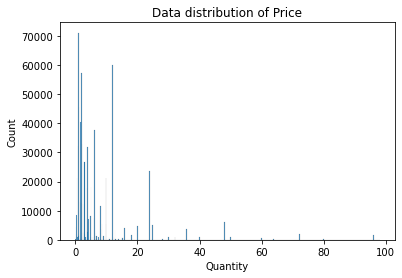

In [31]:
# View distribution
sns.histplot(x = 'Quantity', data=unified_data).set(title="Data distribution of Quantity")

# View distribution
sns.histplot(x='Price', data= unified_data).set(title='Data distribution of Price')

In [32]:
unified_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [33]:
unified_data['StockCode'] = unified_data['StockCode'].astype('str')
unified_data.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [34]:


# save
unified_data.to_parquet('./online_retail_clean.parquet')